### DGM – Black-Scholes

* **Black-Scholes PDE:**

$$
\frac{\partial u}{\partial t}(t, S) + rS \frac{\partial u}{\partial S}(t, S) + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 u}{\partial S^2}(t, S) = ru(t, S)
$$

* **Terminal Condition:**

$$
u(T, S) = (S - K)^+
$$

* **When $S \gg K$ and $S \ll K$, we have:**

$$
\begin{cases}
u(t, S) \approx S - K e^{-r(T - t)}, & \text{as } S \to \infty \\
u(t, S) \approx 0, & \text{as } S \to 0
\end{cases}
$$



In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import math

def sampler(batch, T, S_Max,
            R_Min, R_Max, SIG_Min, SIG_Max,
            K_Min, K_Max, device):
    # sample interior points (t, S, r, sigma, K) uniformly in domain
    t   = torch.rand(batch,1, device=device) * T
    S   = torch.rand(batch,1, device=device) * S_Max
    r   = torch.rand(batch,1, device=device) * (R_Max - R_Min) + R_Min
    sig = torch.rand(batch,1, device=device) * (SIG_Max - SIG_Min) + SIG_Min
    K_  = torch.rand(batch,1, device=device) * (K_Max - K_Min) + K_Min
    X_in = torch.cat([t, S, r, sig, K_], dim=1)

    # sample terminal points: set t = T for payoff condition
    X_T = X_in.clone()
    X_T[:,0:1] = T

    # sample boundary points at S=0 and S=S_Max
    t_b   = torch.rand_like(t) * T
    r_b   = torch.rand_like(r) * (R_Max - R_Min) + R_Min
    sig_b = torch.rand_like(sig) * (SIG_Max - SIG_Min) + SIG_Min
    K_b   = torch.rand_like(K_) * (K_Max - K_Min) + K_Min
    X_b0  = torch.cat([t_b, torch.zeros_like(S),      r_b, sig_b, K_b], dim=1)  # S=0 boundary
    X_b1  = torch.cat([t_b, torch.full_like(S, S_Max), r_b, sig_b, K_b], dim=1)  # S=S_Max boundary
    X_b   = torch.cat([X_b0, X_b1], dim=0)

    return X_in, X_T, X_b

def pde_residual(net, X):
    X = X.clone().detach().requires_grad_(True)
    u = net(X)  # network prediction u(t,S,r,sigma,K)
    # compute first order derivatives [du/dt, du/dS, du/dr, du/dsigma, du/dK]
    grad = torch.autograd.grad(
        outputs=u, inputs=X,
        grad_outputs=torch.ones_like(u),
        create_graph=True, retain_graph=True
    )[0]
    u_t, u_S = grad[:, 0:1], grad[:, 1:2]

    # compute second order derivative d^2u/dS^2
    u_SS = torch.autograd.grad(
        outputs=u_S, inputs=X,
        grad_outputs=torch.ones_like(u_S),
        create_graph=True, retain_graph=True
    )[0][:, 1:2]

    # extract coefficients S, r, sigma
    S   = X[:, 1:2]
    r   = X[:, 2:3]
    sig = X[:, 3:4]

    # PDE residual: u_t + 0.5*sigma^2*S^2*u_SS + r*S*u_S - r*u
    res = u_t + 0.5 * sig.pow(2) * S.pow(2) * u_SS + r * S * u_S - r * u
    return res

def loss_fn(net, X_in, X_T, X_b, S_Max, T):
    # compute PDE loss on interior samples
    res = pde_residual(net, X_in)
    loss_pde = torch.mean(res.pow(2))

    # compute terminal loss: payoff at maturity
    u_T    = net(X_T)
    payoff = torch.relu(X_T[:,1:2] - X_T[:,4:5])  # (S - K)+
    loss_T = torch.mean((u_T - payoff).pow(2))

    # compute boundary loss: u(S=0)=0 and u(S=S_Max)=S - discounted K
    u_b    = net(X_b)
    N = X_b.shape[0] // 2
    # boundary at S=0 should be zero
    bc0 = u_b[:N]
    t_b, S_b, r_b, K_b = X_b[N:,0:1], X_b[N:,1:2], X_b[N:,2:3], X_b[N:,4:5]
    # boundary at S_Max: u = S_Max - K*exp(-r*(T - t))
    bc1 = u_b[N:] - (S_Max - K_b * torch.exp(-r_b * (T - t_b)))
    loss_b = torch.mean(bc0.pow(2)) + torch.mean(bc1.pow(2))

    return loss_pde + loss_T + loss_b, loss_pde, loss_T, loss_b

class DGMBlock(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int):
        super().__init__()
        # gate parameter initializations
        self.U_z = nn.Linear(in_dim, hidden_dim)
        self.W_z = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.U_g = nn.Linear(in_dim, hidden_dim)
        self.W_g = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.U_r = nn.Linear(in_dim, hidden_dim)
        self.W_r = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.U_h = nn.Linear(in_dim, hidden_dim)
        self.W_h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.act = nn.Tanh()

        # Xavier init for all linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, s_prev, s_first):
        z = self.act(self.U_z(x) + self.W_z(s_prev))        # update gate
        g = self.act(self.U_g(x) + self.W_g(s_first))       # forget gate
        r = self.act(self.U_r(x) + self.W_r(s_prev))        # reset gate
        h = self.act(self.U_h(x) + self.W_h(s_prev * r))    # candidate state
        s_next = (1.0 - g) * h + z * s_prev                 # new state
        return s_next

class DGMNet(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, n_layers=3):
        super().__init__()
        # initial linear layer
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)

        # sequence of DGMBlocks
        self.blocks = nn.ModuleList([
            DGMBlock(input_dim, hidden_dim) for _ in range(n_layers)
        ])

        # final output layer to scalar u
        self.output_layer = nn.Linear(hidden_dim, 1)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

        self.act = nn.Tanh()

    def forward(self, x):
        # embed inputs
        s = self.act(self.input_layer(x))
        s_first = s  # store initial state

        # pass through DGM blocks
        for block in self.blocks:
            s = block(x, s, s_first)

        # produce final value
        return self.output_layer(s)

if __name__ == "__main__":
    T, K, R, SIGMA, S_Max = 1.0, 100.0, 0.02, 0.05, 200.0
    batch, epochs, lr = 4096, 10000, 1e-3
    R_Min, R_Max = 0.0, 0.1
    K_Min, K_Max = 95.0, 105.0
    Sig_min, Sig_max = 0.05, 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # initialize network and optimizer
    net = DGMNet(hidden_dim=64).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    start_time = time.time()

    for epoch in range(1, epochs+1):
        # sample points for training
        X_in, X_T, X_b = sampler(
            batch, T, S_Max,
            R_Min, R_Max, Sig_min, Sig_max,
            K_Min, K_Max, device
        )
        # compute losses
        loss, l_pde, l_T, l_b = loss_fn(net, X_in, X_T, X_b, S_Max, T)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch:>4}: total={loss.item():.2e}, "
                  f"PDE={l_pde:.2e}, T={l_T:.2e}, B={l_b:.2e}")

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    filename = f"DGM_{lr}_{batch}_{epochs}.pth"
    torch.save(net.state_dict(), filename)
    print(f"Model saved to {filename}")


Epoch  500: total=3.08e+02, PDE=6.43e+00, T=6.62e+00, B=2.95e+02
Epoch 1000: total=1.76e+01, PDE=5.37e+00, T=5.79e-01, B=1.17e+01
Epoch 1500: total=6.34e+00, PDE=2.86e+00, T=3.86e-01, B=3.09e+00
Epoch 2000: total=2.07e+00, PDE=8.32e-01, T=9.49e-02, B=1.14e+00
Epoch 2500: total=1.18e+00, PDE=5.08e-01, T=8.21e-02, B=5.86e-01
Epoch 3000: total=7.85e-01, PDE=3.57e-01, T=6.93e-02, B=3.59e-01
Epoch 3500: total=9.32e-01, PDE=4.17e-01, T=1.78e-01, B=3.37e-01
Epoch 4000: total=4.71e-01, PDE=2.25e-01, T=8.26e-02, B=1.63e-01
Epoch 4500: total=2.86e-01, PDE=1.73e-01, T=3.93e-02, B=7.39e-02
Epoch 5000: total=6.19e-01, PDE=2.62e-01, T=1.03e-01, B=2.54e-01
Epoch 5500: total=6.03e-01, PDE=1.76e-01, T=1.33e-01, B=2.94e-01
Epoch 6000: total=2.25e-01, PDE=1.00e-01, T=5.32e-02, B=7.17e-02
Epoch 6500: total=1.18e-01, PDE=8.26e-02, T=1.91e-02, B=1.61e-02
Epoch 7000: total=1.09e-01, PDE=7.82e-02, T=1.84e-02, B=1.22e-02
Epoch 7500: total=2.23e-01, PDE=6.51e-02, T=5.08e-02, B=1.07e-01
Epoch 8000: total=8.04e-0

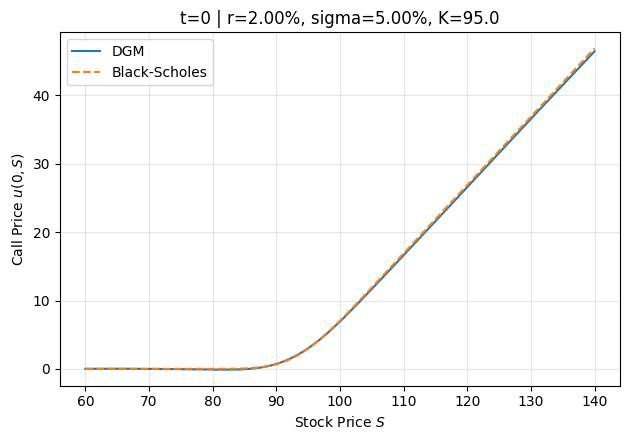

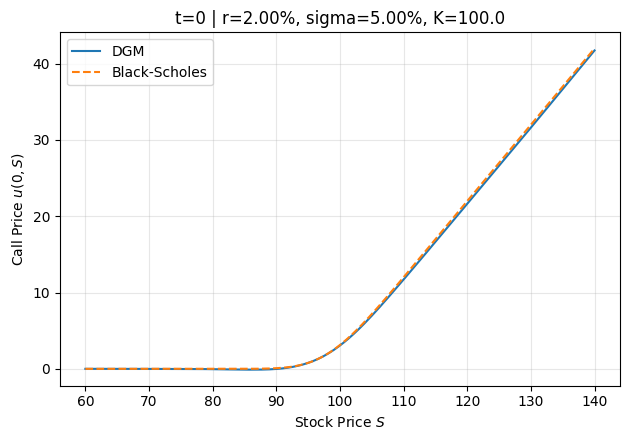

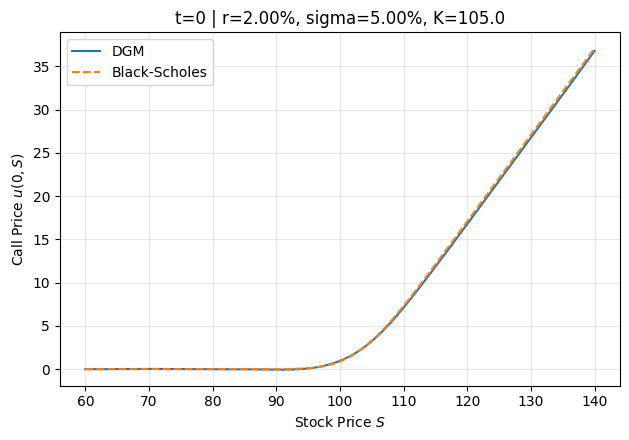

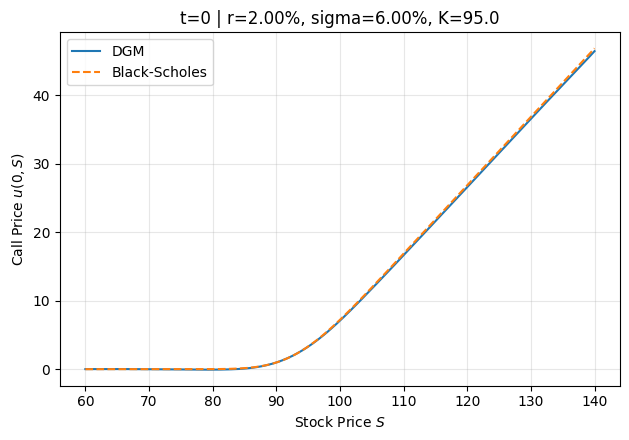

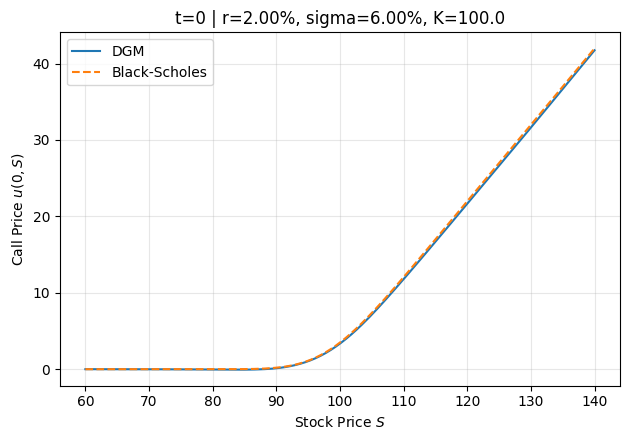

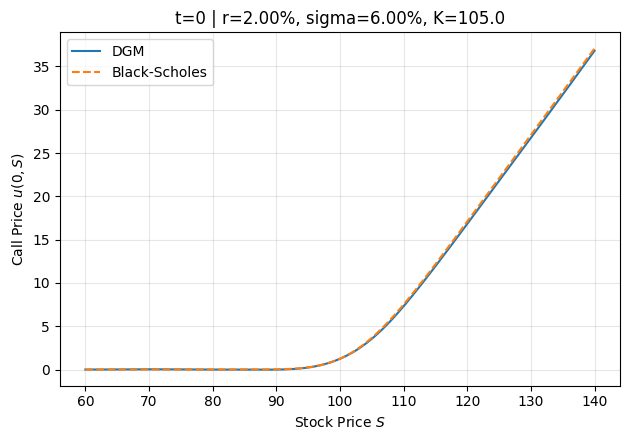

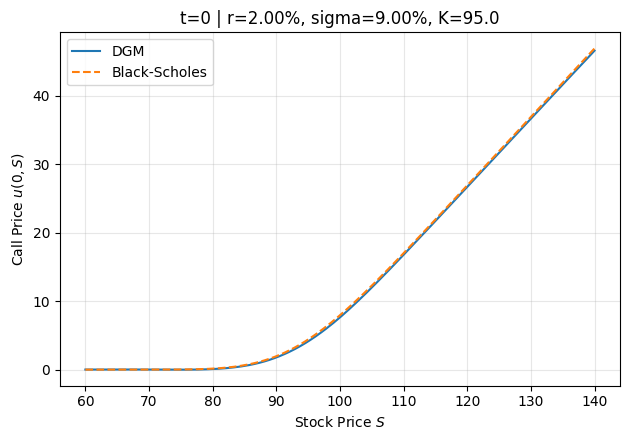

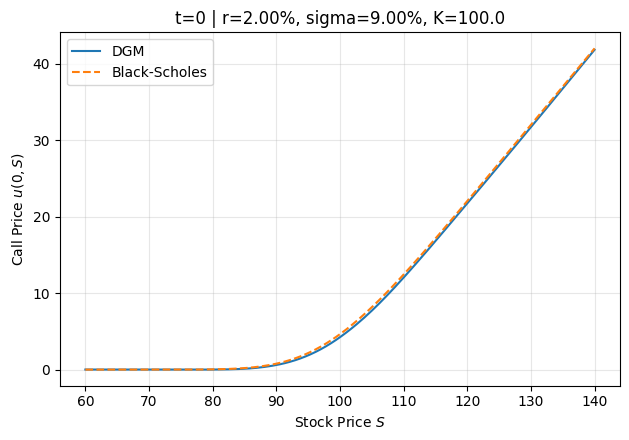

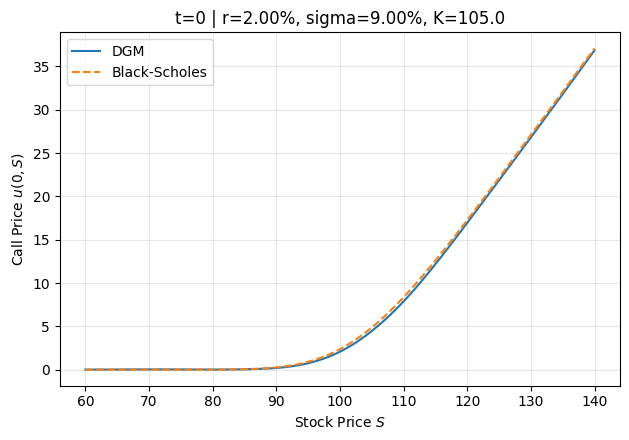

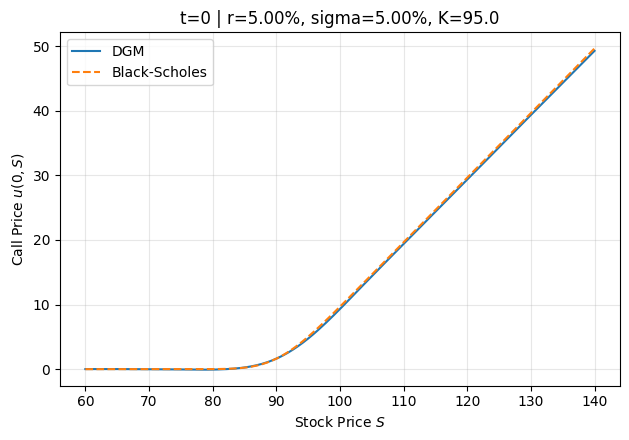

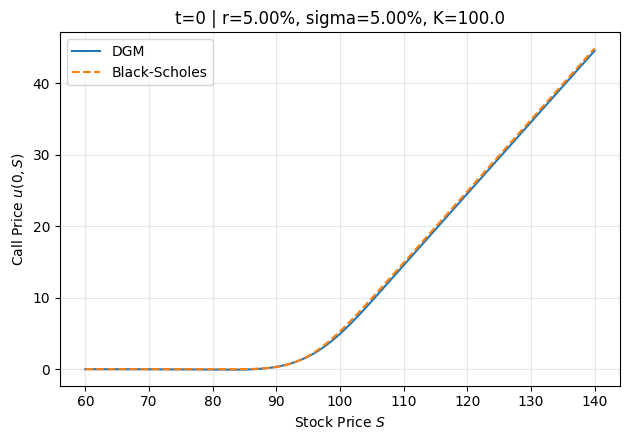

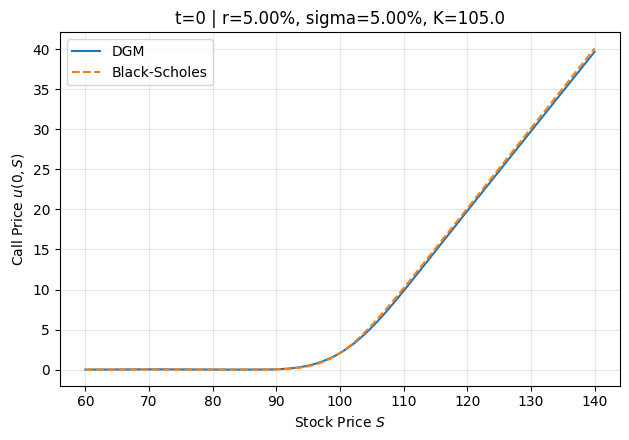

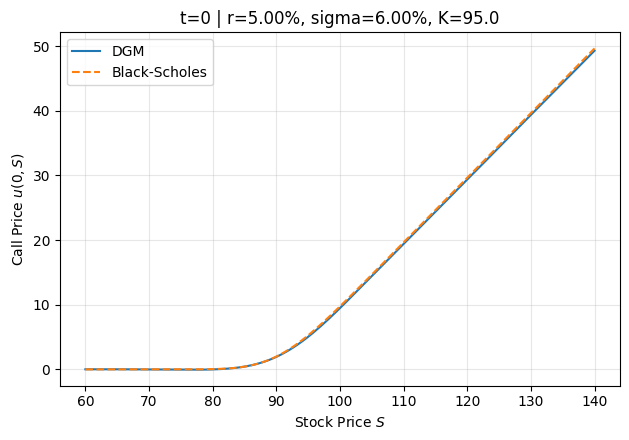

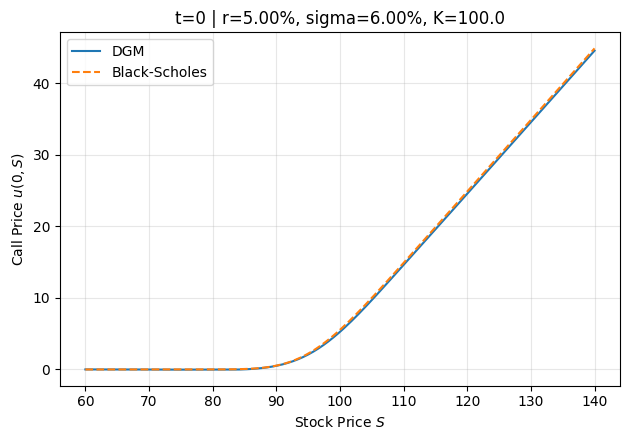

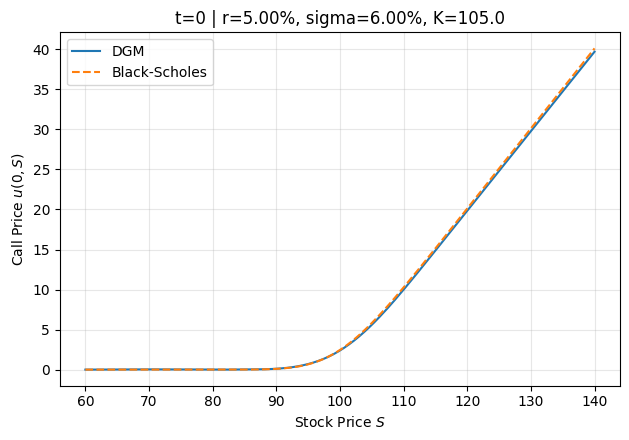

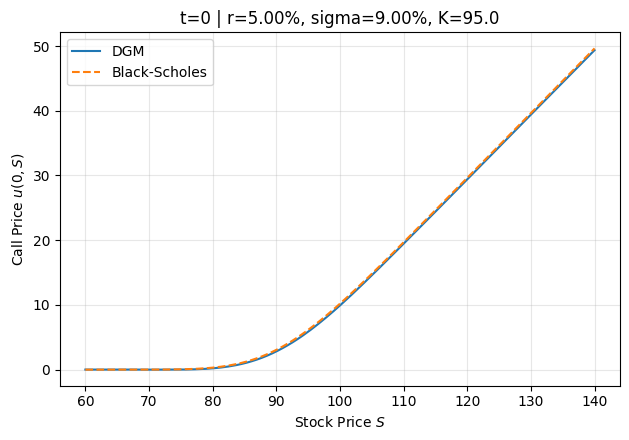

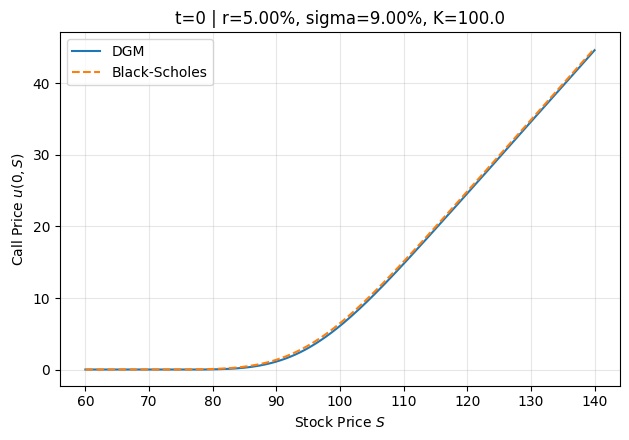

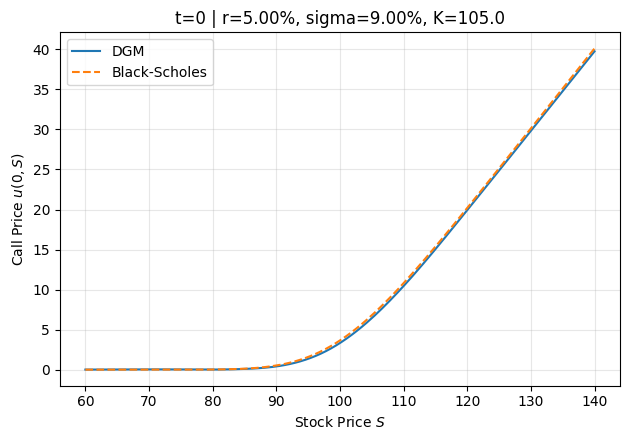

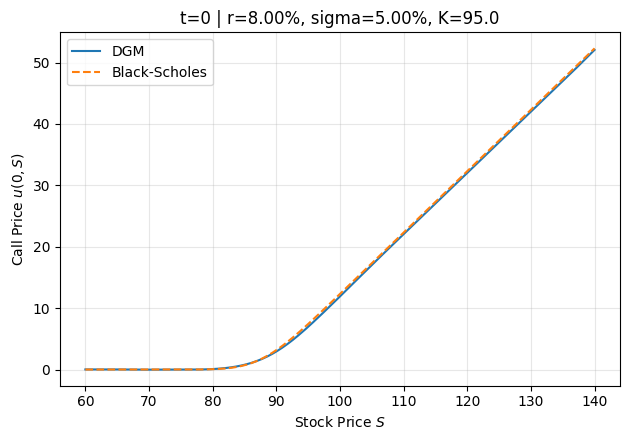

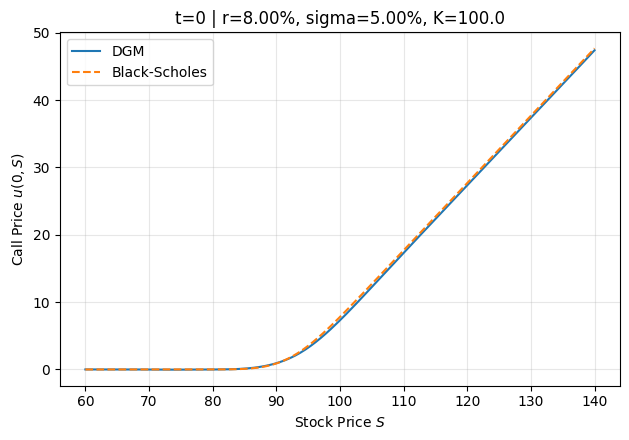

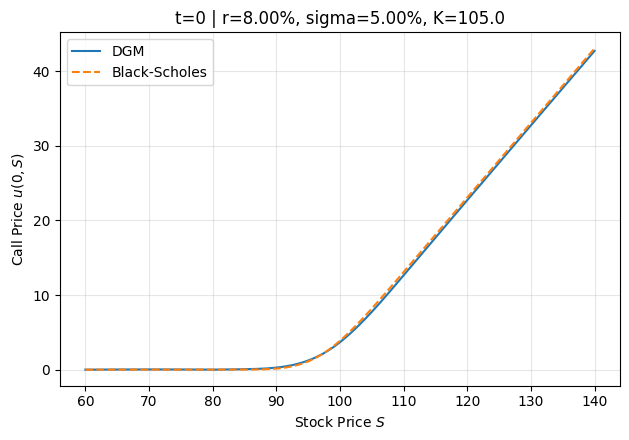

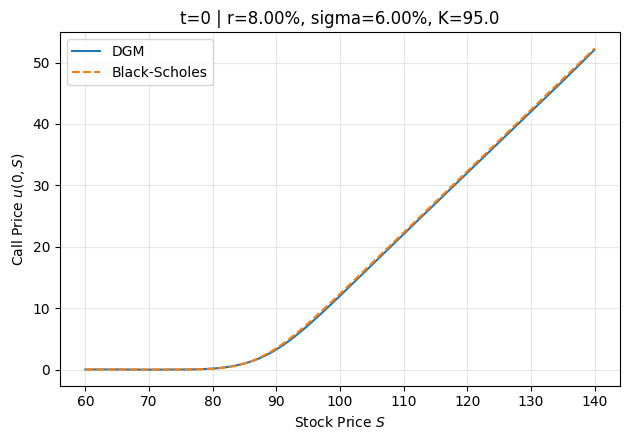

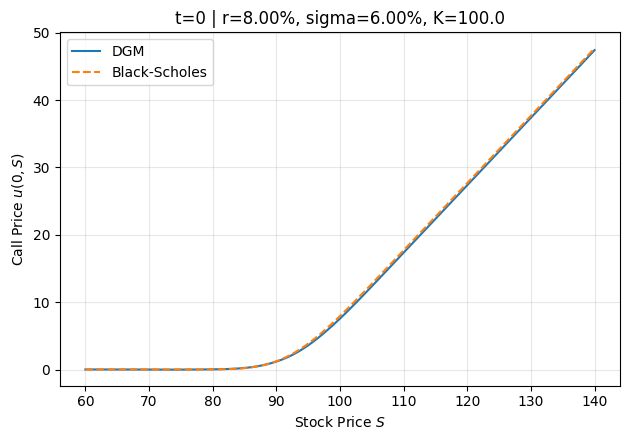

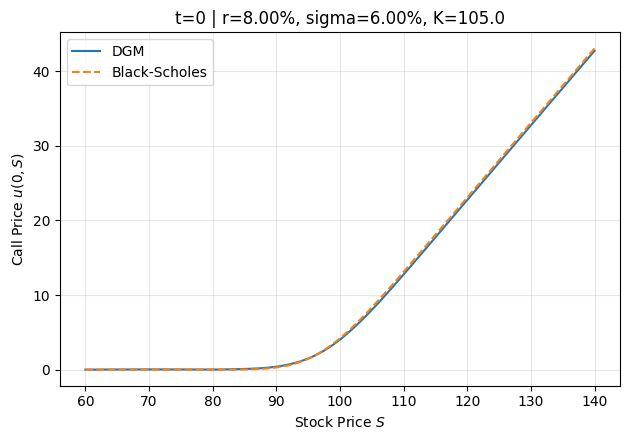

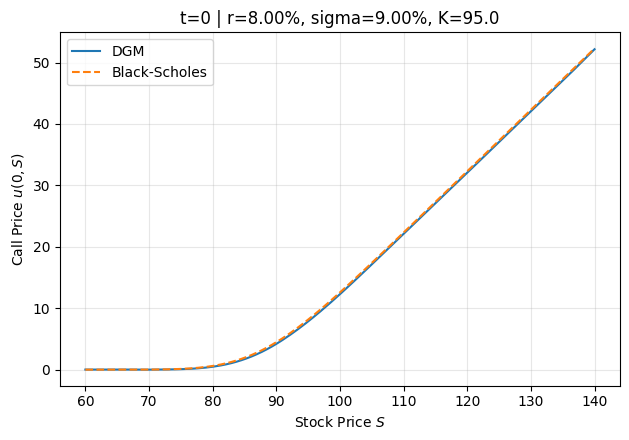

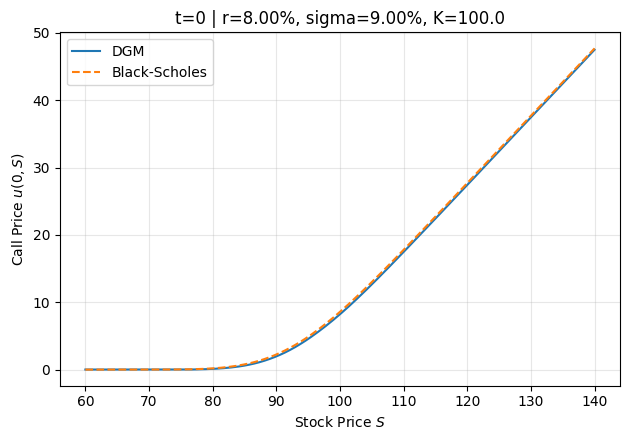

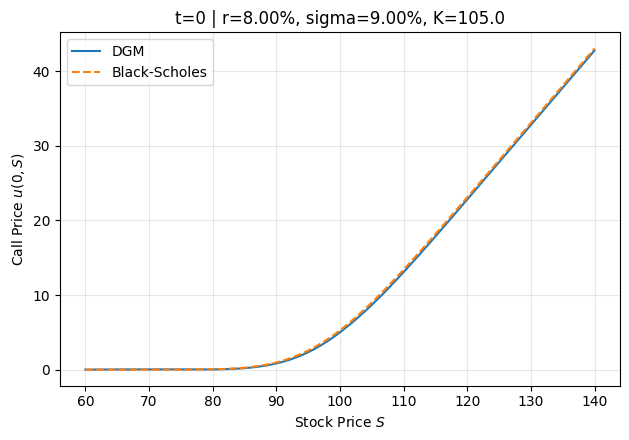


Error Statistics (S in [60,140])
                    AvgAbs    MaxAbs  AvgPct
K     r    sigma                            
95.0  0.02 0.05   0.171048  0.433464  1.4711
100.0 0.02 0.05   0.174563  0.384405  1.6808
105.0 0.02 0.05   0.138411  0.355156  1.7855
95.0  0.02 0.06   0.150589  0.408134  1.0553
100.0 0.02 0.06   0.168186  0.363947  2.0916
105.0 0.02 0.06   0.128108  0.335113  1.7200
95.0  0.02 0.09   0.178787  0.331883  2.7642
100.0 0.02 0.09   0.214793  0.448102  4.3688
105.0 0.02 0.09   0.197952  0.480877  4.6703
95.0  0.05 0.05   0.193891  0.379943  1.8620
100.0 0.05 0.05   0.193017  0.405191  2.3312
105.0 0.05 0.05   0.170917  0.429283  2.2154
95.0  0.05 0.06   0.170986  0.354678  1.5895
100.0 0.05 0.06   0.177251  0.321393  2.2861
105.0 0.05 0.06   0.153368  0.413399  1.8507
95.0  0.05 0.09   0.183546  0.282508  2.7344
100.0 0.05 0.09   0.209306  0.364738  3.8808
105.0 0.05 0.09   0.199032  0.366726  4.0467
95.0  0.08 0.05   0.217303  0.456810  2.2028
100.0 0.08 0.05   0.2

In [29]:
import math, itertools, pathlib
import torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# path to saved model and device configuration
FILE   = "DGM_0.001_2048_10000.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the pre-trained DGM network
net = DGMNet(input_dim=5, hidden_dim=128, n_layers=3).to(DEVICE)
net.load_state_dict(torch.load(FILE, map_location=DEVICE))
net.eval()  # set network to evaluation mode

# set parameters for plotting
T          = 1.0
t_fixed    = 0.0
r_values   = [0.02, 0.05, 0.08]    # interest rate scenarios
sig_values = [0.05, 0.06, 0.09]    # volatility scenarios
K_values   = [95.0, 100.0, 105.0]  # strike price scenarios
# generate stock price grid
S_tensor   = torch.linspace(60, 140, 200, device=DEVICE).unsqueeze(1)
S_np       = S_tensor.cpu().numpy().ravel()

# create output directory for figures
out_dir = pathlib.Path("figs_K")
out_dir.mkdir(exist_ok=True)

# loop over all combinations of parameters and plot model vs. BS formula
for r_cur, sig_cur, K_cur in itertools.product(r_values, sig_values, K_values):
    # assemble input tensor (t, S, r, sigma, K)
    t_tensor   = torch.full_like(S_tensor, t_fixed)
    r_tensor   = torch.full_like(S_tensor, r_cur)
    sig_tensor = torch.full_like(S_tensor, sig_cur)
    K_tensor   = torch.full_like(S_tensor, K_cur)
    X = torch.cat([t_tensor, S_tensor, r_tensor, sig_tensor, K_tensor], dim=1)

    # obtain model prediction
    with torch.no_grad():
        u_pred = net(X).cpu().numpy().ravel()

    # compute Black-Scholes analytical price
    d1 = (np.log(S_np / K_cur) + (r_cur + 0.5 * sig_cur**2) * T) / (sig_cur * math.sqrt(T))
    d2 = d1 - sig_cur * math.sqrt(T)
    u_exact = S_np * norm.cdf(d1) - K_cur * np.exp(-r_cur * T) * norm.cdf(d2)

    # plot DGM vs. Black-Scholes
    plt.figure(figsize=(6.4, 4.5))
    plt.plot(S_np, u_pred, label="DGM")
    plt.plot(S_np, u_exact, "--", label="Black-Scholes")
    plt.title(f"t=0 | r={r_cur:.2%}, sigma={sig_cur:.2%}, K={K_cur}")
    plt.xlabel("Stock Price $S$")
    plt.ylabel("Call Price $u(0,S)$")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# prepare error metrics over the same parameter grid
metrics = []
with torch.no_grad():
    for r_cur, sig_cur, K_cur in itertools.product(r_values, sig_values, K_values):
        # use t=0 for error calculation
        t_tensor   = torch.zeros_like(S_tensor)
        r_tensor   = torch.full_like(S_tensor, r_cur)
        sig_tensor = torch.full_like(S_tensor, sig_cur)
        K_tensor   = torch.full_like(S_tensor, K_cur)
        X = torch.cat([t_tensor, S_tensor, r_tensor, sig_tensor, K_tensor], dim=1)

        # model predictions at t=0
        u_pred = net(X).cpu().numpy().ravel()

        # compute reference BS prices
        d1 = (np.log(S_np / K_cur) + (r_cur + 0.5 * sig_cur**2) * T) / (sig_cur * math.sqrt(T))
        d2 = d1 - sig_cur * math.sqrt(T)
        u_exact = S_np * norm.cdf(d1) - K_cur * np.exp(-r_cur * T) * norm.cdf(d2)

        # compute absolute and relative errors
        abs_err = np.abs(u_pred - u_exact)
        mask    = u_exact >= 1.0  # avoid division by tiny values
        rel_err = abs_err[mask] / u_exact[mask]

        metrics.append({
            'K': K_cur,
            'r': r_cur,
            'sigma': sig_cur,
            'AvgAbs': abs_err.mean(),
            'MaxAbs': abs_err.max(),
            'AvgPct': rel_err.mean() * 100
        })

# assemble results into a DataFrame and print
df = (
    pd.DataFrame(metrics)
      .set_index(["K", "r", "sigma"])
      .round({"AvgAbs": 6, "MaxAbs": 6, "AvgPct": 4})
)

print("\nError Statistics (S in [60,140])")
print(df)
